In [1]:
import numpy as np
import math
import numpy.ma as ma
from evtk.hl import imageToVTK

import matplotlib.pyplot as plt
import time

(500, 500, 50, 20)
1.3690168707382906
0.0
(500, 500, 50)
(250, 250, 25, 20)


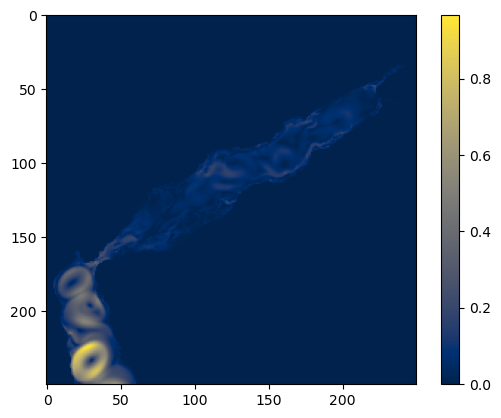

In [2]:
originaEnsemble = np.load('data/redSeaVelocityMagnitude/redSeaEnsemble.npy')
print(originaEnsemble.shape)
print(originaEnsemble.max())
print(originaEnsemble.min())
mean_realization = np.mean(originaEnsemble , axis=3)
print(mean_realization.shape)

# test ensemble: Only portion of ensemble for faster processing
#ensemble = originaEnsemble[250:500, 250:500, 0:50]
ensemble = originaEnsemble[::2,::2,::2,:]
print(ensemble.shape)

trueData = ensemble[:,:,0,0]
img = plt.imshow(trueData, cmap="cividis")
plt.colorbar(img)

In [3]:
# At each grid vertex, compute the probabillity of values being less than and greater than the isovalue
def computePositiveNegativeProbabilities(ensemble, isovalue, confidence, distributionModel, numBins):
    h, w, d, numMembers = ensemble.shape
    minimumGrid = np.zeros((h,w,d))
    maximumGrid = np.zeros((h,w,d))
    meanGrid = np.zeros((h,w,d))
    mostProbableGrid = np.zeros((h,w,d))
    
    meanGaussian = np.zeros((h,w,d))
    stdGaussian = np.zeros((h,w,d))
    for i in range(h):
        for j in range(w):
            for k in range(d):
                minimum = math.inf
                maximum = -math.inf
                t = np.array([])
                for idx in range(numMembers):
                    t = np.append(t, [ensemble[i,j,k,idx]])
                    if(ensemble[i,j,k,idx] < minimum):
                        minimum = ensemble[i,j,k,idx]
                    if(ensemble[i,j,k,idx] > maximum):
                        maximum = ensemble[i,j,k,idx]    
                tMean = np.mean(t,0)
                tVar = np.var(t,0)
                tStd = math.sqrt(tVar)
            
                #Uniform
                minimumGrid[i,j,k] = minimum
                maximumGrid[i,j,k] = maximum   
            
                #Gaussian
                meanGaussian[i,j,k] = tMean
                stdGaussian[i,j,k] = tStd
            
    # Compute probabilitis based of confidence value (between 0 and 100)
    for i in range(h):
        for j in range(w):
            for k in range(d):
            
                minimum=minimumGrid[i,j,k]
                maximum=maximumGrid[i,j,k]
            
                minimumGrid[i,j,k]=minimum
                maximumGrid[i,j,k]=maximum
            
                meanVal = (maximum + minimum)/2
            
                confidenceFraction = 0.01*confidence*(meanVal - minimum)
            
                newMinimum = meanVal - confidenceFraction
                newMaximum = meanVal + confidenceFraction
            
                # Revise minimum and maximum grids based on confidence information
                minimumGrid[i,j,k]=newMinimum
                maximumGrid[i,j,k]=newMaximum
                meanGrid[i,j,k] = (newMinimum + newMaximum)/2
    
                #plt.figure()
                #plt.imshow(minimumGrid)
                #plt.contour(minimumGrid, levels=[isovalue])
    
                #plt.figure()
                #plt.imshow(maximumGrid)
                #plt.contour(maximumGrid, levels=[isovalue])
    
    # Compute negative and positive probabilities
    # Pr(value <= isovalue)
    negativeProbabilitiesGrid = np.zeros((h,w,d))
    # Pr(value > isovalue)
    positiveProbabilitiesGrid = np.zeros((h,w,d))
    for i in range(h):
        for j in range(w):
            for k in range(d):
                minimum = minimumGrid[i,j,k]
                maximum = maximumGrid[i,j,k]
                meanVal = meanGrid[i,j,k]
                if (isovalue <= minimum):
                    positiveProbabilitiesGrid[i,j,k] = 1.0
                    negativeProbabilitiesGrid[i,j,k] = 0.0
                elif (isovalue >= maximum):    
                    positiveProbabilitiesGrid[i,j,k] = 0.0
                    negativeProbabilitiesGrid[i,j,k] = 1.0
                else:
                    if distributionModel == 'theD':
                        theD = np.sort(ensemble[i,j,k,:])
                        probIndex = 0
                        for dId in range(len(theD)):
                            if(isovalue >= theD[dId]):
                                probIndex = probIndex + 1
                            else:
                                break
                        tempNegativeProb = (probIndex+(isovalue-theD[probIndex-1])/(theD[probIndex]-theD[probIndex-1]))/(len(theD)-1)
                        negativeProbabilitiesGrid[i,j,k] = tempNegativeProb
                        positiveProbabilitiesGrid[i,j,k] = 1.0 - negativeProbabilitiesGrid[i,j,k] 
                    elif distributionModel == 'TheQ':
                        quants = np.array([])
                        quants = np.append(quants, 0)
                        quant  = 1/(numBins)
                        for q in range(numBins-1):
                            quants = np.append(quants, quant)
                            quant = quant + 1/numBins
                        quants = np.append(quants, 1)
                        theQ = np.quantile(ensemble[i,j,k,:], quants)
                        probIndex = 0
                        for qId in range(len(theQ)):
                            if(isovalue >= theQ[qId]):
                                probIndex = probIndex + 1
                            else:
                                break
                        negativeProbabilitiesGrid[i,j,k] = quants[probIndex-1]+1/numBins*(isovalue-theQ[probIndex-1])/(theQ[probIndex]-theQ[probIndex-1])
                        positiveProbabilitiesGrid[i,j,k] = 1.0 - negativeProbabilitiesGrid[i,j,k]
                    elif distributionModel == 'uniform':
                        positiveProbabilitiesGrid[i,j,k] = (maximum - isovalue)/(maximum - minimum)
                        negativeProbabilitiesGrid[i,j,k] = 1.0 - positiveProbabilitiesGrid[i,j,k]
                    elif distributionModel == 'Gaussian':
                        tempMean = meanGaussian[i,j,k]
                        tempStd = stdGaussian[i,j,k]
                        negativeProbabilitiesGrid[i,j,k] = 0.5*(1 + math.erf((isovalue - tempMean)/(math.sqrt(2)*tempStd)))
                        positiveProbabilitiesGrid[i,j,k] = 1.0 - negativeProbabilitiesGrid[i,j,k]
                    elif distributionModel == 'Histogram':
                        hist, bin_edges = np.histogram(ensemble[i,j,k,:], bins=numBins)
                        # Normalize histogram
                        hist = hist/np.sum(hist)
                        tempNegativeProb = 0
                        for binId in range(numBins):
                            low = bin_edges[binId]
                            high = bin_edges[binId+1]
                            if (isovalue <= low):
                                tempNegativeProb = tempNegativeProb + 0
                            elif (isovalue >= high):
                                tempNegativeProb = tempNegativeProb + hist[binId]
                            else:
                                tempNegativeProb = tempNegativeProb + hist[binId]*((isovalue - bin_edges[binId])/(bin_edges[binId+1]-bin_edges[binId]))
                        negativeProbabilitiesGrid[i,j,k] = tempNegativeProb
                        positiveProbabilitiesGrid[i,j,k] = 1.0 - negativeProbabilitiesGrid[i,j,k]
                    
                    else:
                        print('No valid model')
            
                # Compute most probable grid
                if(positiveProbabilitiesGrid[i,j,k] > negativeProbabilitiesGrid[i,j,k]):
                    mostProbableGrid[i,j,k] = (meanVal + maximum)/2
                else:
                    mostProbableGrid[i,j,k] = (minimum + meanVal)/2  
            
    return positiveProbabilitiesGrid, negativeProbabilitiesGrid, maximumGrid, minimumGrid, mostProbableGrid

In [4]:
def computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid):
    h, w, d = positiveProbabilitiesGrid.shape
    MStopologyCasesProbabilities = np.zeros((h-1,w-1,d-1, 256))
    # Record number of cases per cell as well
    numCases = np.zeros((h-1,w-1,d-1))

    tempNumCases = 1
    for i in range(h-1):
        for j in range(w-1):
            for k in range(d-1):
            
                x1Positive = positiveProbabilitiesGrid[i,j,k]
                x1Negative = negativeProbabilitiesGrid[i,j,k]
                x1Sign = np.array([x1Negative, x1Positive])
                if(x1Positive > 0) and (x1Positive < 1):
                    tempNumCases = tempNumCases*2
            
                x2Positive = positiveProbabilitiesGrid[i+1,j,k]
                x2Negative = negativeProbabilitiesGrid[i+1,j,k]
                x2Sign = np.array([x2Negative, x2Positive])
                if(x2Positive > 0) and (x2Positive < 1):
                    tempNumCases = tempNumCases*2
            
                x3Positive = positiveProbabilitiesGrid[i+1,j+1,k]
                x3Negative = negativeProbabilitiesGrid[i+1,j+1,k]
                x3Sign = np.array([x3Negative, x3Positive])
                if(x3Positive > 0) and (x3Positive < 1):
                    tempNumCases = tempNumCases*2
            
                x4Positive = positiveProbabilitiesGrid[i,j+1,k]
                x4Negative = negativeProbabilitiesGrid[i,j+1,k]
                x4Sign = np.array([x4Negative, x4Positive])
                if(x4Positive > 0) and (x4Positive < 1):
                    tempNumCases = tempNumCases*2
                    
                x5Positive = positiveProbabilitiesGrid[i,j,k+1]
                x5Negative = negativeProbabilitiesGrid[i,j,k+1]
                x5Sign = np.array([x5Negative, x5Positive])
                if(x5Positive > 0) and (x5Positive < 1):
                    tempNumCases = tempNumCases*2
            
                x6Positive = positiveProbabilitiesGrid[i+1,j,k+1]
                x6Negative = negativeProbabilitiesGrid[i+1,j,k+1]
                x6Sign = np.array([x6Negative, x6Positive])
                if(x6Positive > 0) and (x6Positive < 1):
                    tempNumCases = tempNumCases*2
            
                x7Positive = positiveProbabilitiesGrid[i+1,j+1,k+1]
                x7Negative = negativeProbabilitiesGrid[i+1,j+1,k+1]
                x7Sign = np.array([x7Negative, x7Positive])
                if(x7Positive > 0) and (x7Positive < 1):
                    tempNumCases = tempNumCases*2
            
                x8Positive = positiveProbabilitiesGrid[i,j+1,k+1]
                x8Negative = negativeProbabilitiesGrid[i,j+1,k+1]
                x8Sign = np.array([x8Negative, x8Positive])
                if(x8Positive > 0) and (x8Positive < 1):
                    tempNumCases = tempNumCases*2
                
                numCases[i,j,k] = tempNumCases
                # Reset tempNumCases for next iteration
                tempNumCases = 1
                
                count = 0
                for s1 in range(2):
                    for s2 in range(2):
                        for s3 in range(2):
                            for s4 in range(2):
                                for s5 in range(2):
                                    for s6 in range(2):
                                        for s7 in range(2):
                                            for s8 in range(2):
                                                MStopologyCasesProbabilities[i,j,k,count] = x1Sign[s1]*x2Sign[s2]*x3Sign[s3]*x4Sign[s4]*x5Sign[s5]*x6Sign[s6]*x7Sign[s7]*x8Sign[s8]
                                                count+=1
              
            
    # Compute entropy of probability distribution
    entropy = np.zeros((h-1,w-1,d-1))
        
    #for i in range(256):
        
    #    probs = MStopologyCasesProbabilities[:,:,:,i]
    #    res = ma.log2(probs);
    #    entropy += np.multiply(-probs,res)
        
        
    for i in range(h-1):
        for j in range(w-1):
            for k in range(d-1):
                entropyValue = 0
                res = 0
                for num in range(256):
                    probs = MStopologyCasesProbabilities[i,j,k,num]
                    if probs > 0:
                        res = ma.log2(probs)
                    entropyValue += np.multiply(-probs,res)    
                entropy[i,j,k] = entropyValue
        
    return MStopologyCasesProbabilities, entropy, numCases

In [5]:
def probabilisticMarchingSquares(positiveProbabilitiesGrid, negativeProbabilitiesGrid):
    
    h, w, d = positiveProbabilitiesGrid.shape
    # Record number of cases per cell as well
    crossingProbabilities = np.zeros((h-1,w-1,d-1))
    for i in range(h-1):
        for j in range(w-1):
            for k in range(d-1):
                nonCrossingProbability1 = positiveProbabilitiesGrid[i,j,k]*positiveProbabilitiesGrid[i+1,j,k]*positiveProbabilitiesGrid[i,j+1,k]*positiveProbabilitiesGrid[i+1,j+1,k]*positiveProbabilitiesGrid[i,j,k+1]*positiveProbabilitiesGrid[i+1,j,k+1]*positiveProbabilitiesGrid[i,j+1,k+1]*positiveProbabilitiesGrid[i+1,j+1,k+1]
                nonCrossingProbability2 = negativeProbabilitiesGrid[i,j,k]*negativeProbabilitiesGrid[i+1,j,k]*negativeProbabilitiesGrid[i,j+1,k]*negativeProbabilitiesGrid[i+1,j+1,k]*negativeProbabilitiesGrid[i,j,k+1]*negativeProbabilitiesGrid[i+1,j,k+1]*negativeProbabilitiesGrid[i,j+1,k+1]*negativeProbabilitiesGrid[i+1,j+1,k+1]
                nonCrossingProbability = nonCrossingProbability1 + nonCrossingProbability2
                crossingProbability = 1.0 - nonCrossingProbability
                crossingProbabilities[i,j,k] = crossingProbability
    return crossingProbabilities

In [6]:
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("starting at " + current_time)

starting at 20:39:34


In [7]:
isovalue = 0.15

start = time.monotonic()
[positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue, 100, 'theD',5)
MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
end = time.monotonic()

#plt.figure()
#plt.imshow(positiveProbabilitiesGrid)
#plt.contour(positiveProbabilitiesGrid, levels=[0.5])
#MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
#MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)

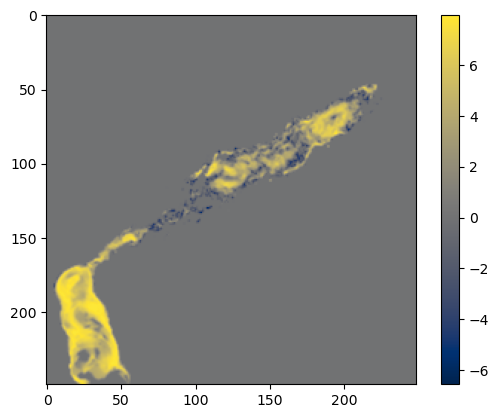

In [8]:
plt.figure()
img1 = plt.imshow(entropy[:,:,0], cmap="cividis")
plt.colorbar(img1)

In [9]:
#theD model result
print("TheD model ========= entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")

# Uniform model result
start = time.monotonic()
[positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue, 100, 'uniform',5)
MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
end = time.monotonic()
print("Uniform model ====== entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")

# Gaussian model result
start = time.monotonic()
[positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue, 100, 'Gaussian',5)
MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
end = time.monotonic()

print("Guassian model ===== entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")

# Histogram model result
theBins = [2,3,4,5,10,15,25]

for bin in theBins:
    start = time.monotonic()
    [positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue, 100, 'Histogram',bin)
    MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
    end = time.monotonic()
    #plt.figure()
    #img1 = plt.imshow(entropy)
    #plt.colorbar(img1) '{:3d}'.format(99)
    print("Histogram model, bins: " + '{:4d}'.format(bin) + " ===== entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")



TheD model ========= entropy sum: 218368.58, entropy avg: 0.15, runtime: 1392.06 seconds
Uniform model ====== entropy sum: 339110.23, entropy avg: 0.23, runtime: 1407.92 seconds
Guassian model ===== entropy sum: 272221.33, entropy avg: 0.18, runtime: 1409.27 seconds
Histogram model, bins:    2 ===== entropy sum: 293768.38, entropy avg: 0.20, runtime: 1407.27 seconds
Histogram model, bins:    3 ===== entropy sum: 283551.34, entropy avg: 0.19, runtime: 1406.45 seconds
Histogram model, bins:    4 ===== entropy sum: 280879.85, entropy avg: 0.19, runtime: 1403.38 seconds
Histogram model, bins:    5 ===== entropy sum: 279988.95, entropy avg: 0.19, runtime: 1414.19 seconds
Histogram model, bins:   10 ===== entropy sum: 280791.94, entropy avg: 0.19, runtime: 1348.22 seconds
Histogram model, bins:   15 ===== entropy sum: 281554.82, entropy avg: 0.19, runtime: 1325.25 seconds
Histogram model, bins:   25 ===== entropy sum: 282226.76, entropy avg: 0.19, runtime: 1328.23 seconds
Quantile model, num

In [11]:
theQuarts = [2,3,4,5,10,15,25]

for q in theQuarts:
    start = time.monotonic()
    [positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue, 100, 'TheQ',q)
    MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
    end = time.monotonic()
    #plt.figure()
    #img1 = plt.imshow(entropy)
    #plt.colorbar(img1)
    print("Quantile model, num quants: " + '{:4d}'.format(q) + " ===== entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")

Quantile model, num quants:    2 ===== entropy sum: 335721.23, entropy avg: 0.23, runtime: 1419.91 seconds
Quantile model, num quants:    3 ===== entropy sum: 307921.59, entropy avg: 0.21, runtime: 1430.59 seconds
Quantile model, num quants:    4 ===== entropy sum: 292895.70, entropy avg: 0.20, runtime: 1427.28 seconds


KeyboardInterrupt: 

In [12]:
theQuarts = [5,10,15,25]

for q in theQuarts:
    start = time.monotonic()
    [positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue, 100, 'TheQ',q)
    MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
    end = time.monotonic()
    #plt.figure()
    #img1 = plt.imshow(entropy)
    #plt.colorbar(img1)
    print("Quantile model, num quants: " + '{:4d}'.format(q) + " ===== entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")

Quantile model, num quants:    5 ===== entropy sum: 284453.83, entropy avg: 0.19, runtime: 1460.59 seconds
Quantile model, num quants:   10 ===== entropy sum: 268027.89, entropy avg: 0.18, runtime: 1436.48 seconds
Quantile model, num quants:   15 ===== entropy sum: 265568.00, entropy avg: 0.18, runtime: 1442.72 seconds
Quantile model, num quants:   25 ===== entropy sum: 264017.42, entropy avg: 0.18, runtime: 1471.76 seconds
